In [ ]:
#!pip install gym
#!pip install opencv-python
#!pip install keras
#!pip install tensorflow
#!pip install tensorflow-gpu

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
#import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import gym
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [ ]:
class Custom_Env(Env):
    def __init__(self):
        self.action_space = Discrete(4,)
        
        # Define the bounds for each parameter
        self.x_min, self.x_max = 0, 2
        self.y_min, self.y_max = 0, 2
        self.angle_min, self.angle_max = -180, 180

        # Define the observation space
        self.observation_space = Box(
            low=np.array([self.x_min, self.y_min, self.angle_min]),
            high=np.array([self.x_max, self.y_max, self.angle_max]),
            dtype=np.float32
        )
        
        self.state = np.array([random.uniform(self.x_min, self.x_max), 
                               random.uniform(self.y_min, self.y_max), 
                               random.uniform(self.angle_min, self.angle_max)])
        
    
    def step(self, action):
        x = self.state[0]
        y = self.state[1]
        angle = self.state[2]
        
        #if action == 0:   #Do nothing
        #    [x,y,angle] = [x,y,angle]
        
        if action  == 0:  #Move Forward
            x += 0.2 * np.cos(np.deg2rad(angle))
            y += 0.2 * np.sin(np.deg2rad(angle))

            x = np.max([0, (np.min([x,2]))])
            y = np.max([0, (np.min([y,2]))])
        
        elif action == 1:   #Move Backward
            x -= 0.2 * np.cos(np.deg2rad(angle))
            y -= 0.2 * np.sin(np.deg2rad(angle))

            x = np.max([0, (np.min([x,2]))])
            y = np.max([0, (np.min([y,2]))])
        
        elif action == 2:   #Turn Left
            angle += 0.5
            if angle > 180:
              angle -= 360
        
        elif action == 3:   #Turn Right
            angle -= 0.5
            if angle < -180:
              angle += 360
        
        next_state = np.array([x, y, angle])
        
        if (abs(x)<5e-2) and (abs(y)<5e-2) and (abs(angle)<1):
            reward = 100
            done = True
        else:
            # Define the target parking spot coordinates
            target_x = 0.0
            target_y = 0.0

            # Calculate the distance to the target parking spot
            distance_to_target = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)

            # Define the desired angle for parking
            target_angle = 0.0

            # Calculate the angle difference from the desired angle
            angle_difference = abs(angle - target_angle)

            # Define the rewards and penalties
            distance_reward = -0.1 * distance_to_target  # Encourage getting closer to the target
            angle_penalty = -10.0 * angle_difference  # Penalize deviations from the desired angle

            # Calculate the overall reward
            reward = distance_reward + angle_penalty

            #reward = -10 * (x**4 + y**2 + (angle/np.pi)**4)
            done = False
        
        info = {}
        
        self.state = next_state
        
        return self.state, reward, done, info

    '''
    def render(self, render_mode ='human'):
        # Render the environment (optional)
        if render_mode  == 'human':
            # Implement human-readable rendering (e.g., print to console)
            print("Current state:", self.state)
        elif render_mode  == 'rgb_array':
            # Implement rendering as an RGB array (e.g., for video recording)
            # Return the RGB array representing the rendered state
            rendered_state = self._render_state_as_rgb()

            return rendered_state
    '''

    def render(self, render_mode='human'):
        if render_mode  == 'human':
            # Implement human-readable rendering (e.g., print to console)
            print("Current state:", self.state)

        elif render_mode == 'rgb_array':
            # Extract the x and y coordinates from the state
            x, y, angle= self.state

            # Create a plot and set the axis limits
            fig, ax = plt.subplots()
            ax.set_xlim([-1, 3])
            ax.set_ylim([-1, 3])

            # Define the dimensions of the car rectangle
            car_length = 1.5
            car_width = 0.5

            # Calculate the coordinates of the car's corners
            dx = car_length / 2 * np.cos(np.deg2rad(angle))
            dy = car_length / 2 * np.sin(np.deg2rad(angle))
            car_corners = [
                (x + dx - car_width / 2 * np.sin(np.deg2rad(angle)), y + dy + car_width / 2 * np.cos(np.deg2rad(angle))),
                (x + dx + car_width / 2 * np.sin(np.deg2rad(angle)), y + dy - car_width / 2 * np.cos(np.deg2rad(angle))),
                (x - dx + car_width / 2 * np.sin(np.deg2rad(angle)), y - dy - car_width / 2 * np.cos(np.deg2rad(angle))),
                (x - dx - car_width / 2 * np.sin(np.deg2rad(angle)), y - dy + car_width / 2 * np.cos(np.deg2rad(angle)))
            ]

            # Create a rectangle patch representing the car
            car_rectangle = patches.Polygon(car_corners, closed=True, fc='blue', alpha=0.5)
            ax.add_patch(car_rectangle)

            # Plot the center of the car as a point
            ax.plot(x, y, 'ro', markersize=1)

            # Plot an arrow representing the orientation
            arrow_length = 0.8
            arrow_dx = arrow_length * np.cos(np.deg2rad(angle))
            arrow_dy = arrow_length * np.sin(np.deg2rad(angle))
            ax.arrow(x, y, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='blue')

            # Display the numerical values of center coordinates and angle
            ax.text(x + 1, y + 1, f'({x:.2f}, {y:.2f}, {angle:.2f})', fontsize=10)
            #ax.text(x + 1, y + 1.5, f'Angle: {angle:.2f}', fontsize=10)

            # Set the aspect ratio and display the plot
            ax.set_aspect('equal')
            plt.show()
    
    def reset(self):
        self.state = np.array([random.uniform(self.x_min, self.x_max), 
                               random.uniform(self.y_min, self.y_max), 
                               random.uniform(self.angle_min, self.angle_max)])
        return self.state
    
    
  

In [ ]:
env = Custom_Env()
print('No. of Obseravable parameters: ', env.observation_space.shape[0])
print('No. of Actions: ', env.action_space.n)
#print(random.randrange(env.action_space.n))

initial_state = env.reset()
print('Sample Initial State: ', initial_state)

No. of Obseravable parameters:  3
No. of Actions:  4
Sample Initial State:  [ 1.12509616  0.6611887  94.78651287]


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Sample Action:  2


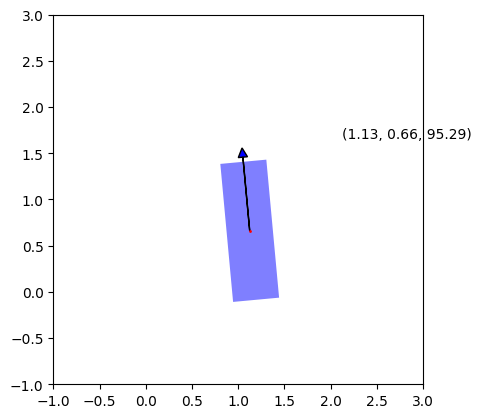

In [ ]:
action = env.action_space.sample()
print('Sample Action: ', action)
env.step(action)
env.render(render_mode='rgb_array')

In [ ]:
# Neural Network model for Deep Q Learning
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 256 nodes
    X = Dense(256, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Hidden layer with 512 nodes
    X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 512 nodes
    X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='CartPole_DQN_model')
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model


In [ ]:
class DQNAgent:
    def __init__(self):
        self.env = Custom_Env()
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 10
        self.memory = deque()
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 32
        self.train_start = 50

        # create main model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))
        
    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)

        for i in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)
            
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            
            #x_list = []
            #y_list = []
            #angle_list = []

            while not done:
                self.env.render()

                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                #x_list.append(next_state[0])
                #y_list.append(next_state[1])
                #angle_list.append(next_state[2])

                next_state = np.reshape(next_state, [1, self.state_size])

                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:                   
                    print("episode: {}/{}, score: {}, e: {:.2}".format(e, self.EPISODES, i, self.epsilon))
                    print("Saving trained model as cartpole-dqn.h5")
                    self.save("RL_DQN_Model.h5")
                self.replay()
                
        #return [x_list, y_list, angle_list]

    def test(self):
        self.load("RL_DQN_Model.h5")
        for e in range(1):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render(render_mode='rgb_array')
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break


In [ ]:
if __name__ == "__main__":


    agent = DQNAgent()
    agent.run()
    #agent.test()


Model: "CartPole_DQN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_21 (Dense)            (None, 256)               1024      
                                                                 
 dense_22 (Dense)            (None, 512)               131584    
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 64)         

KeyboardInterrupt: ignored

In [ ]:
'np.max([-181,-180])

-180

In [ ]:
states.shape

NameError: ignored

In [ ]:
env = Custom_Env()
initial_state = env.reset()

done = False
total_reward = 0

while not done:
    action = env.action_space.sample()  # Replace with your desired action selection method
    next_state, reward, done, info = env.step(action)
    #env.render()
    #plt.imshow(rendered_state)
    #plt.axis('off')
    #plt.show()
    total_reward += reward
    #print('Action: {}, Total Reward: {}'.format(action, total_reward))
    # Perform any necessary logging or visualization

    if done:
        print("Episode finished with a total reward of:", total_reward)

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
